In [3]:
%matplotlib inline
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner
import pickle 

home_dir = '../../'

from plot import draw_corner, draw_kepler_results
from utils import rv_model, log_likelihood, log_prior, sample_prior, get_kepler_params_and_log_jac


In [15]:
random_id = '6256' # long with few observations - NF not well trained
random_id = '688' # n=25 obs - samples all over the places
random_id = '3028' # n=50 obs - samples concentrated

with open(home_dir + 'results_{:s}.pkl'.format(random_id), 'rb') as f:
    results = pickle.load(f)
# ], results
# chains, nf_samples, prior_samples, optimized_init, config, true_params, n_obs,rv_obs, t, prior_kwargs, rv_err, loss_vals, local_accs, global_accs = results['chains'], results['nf_samples'], results['prior_samples'], results['optimized_init'], results['config'], results['true_params'], results['n_obs'], results['rv_obs'], results['t'], results['prior_kwargs'], results['rv_err'], 
# results['loss_vals'['local_accs'], results['global_accs']

for key,val in results.items():
        exec(key + '=val')

labels = ['v0', 'log_s2', 'log_period', 'log_k', 'sin_phi_',
                            'cos_phi_', 'ecc_', 'sin_w_', 'cos_w_']


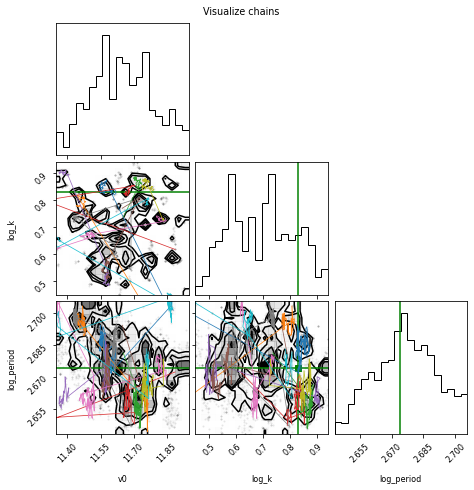

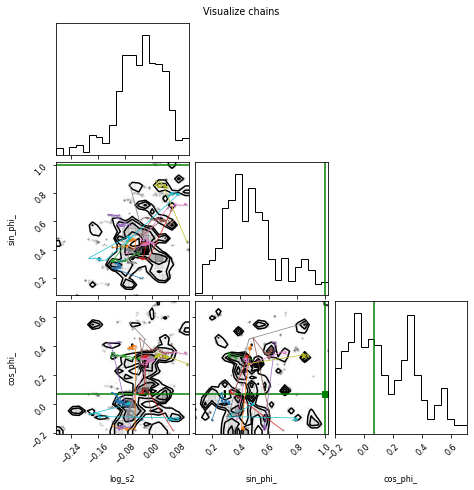

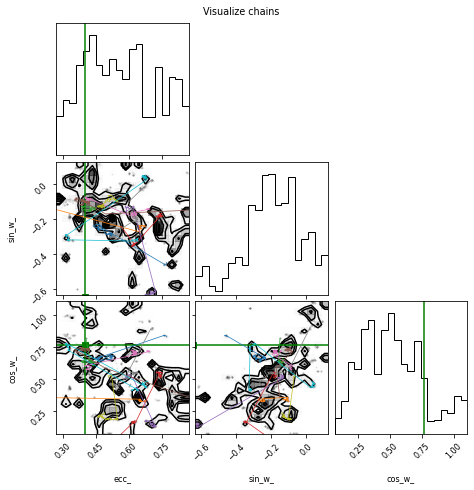

In [19]:
# fig_corner = draw_corner(chains, true_params, labels, labelpad=0.3)

for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:

    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=10, n_last_spls=100)
   

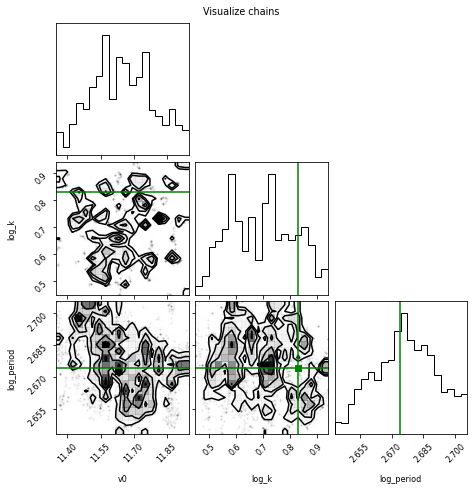

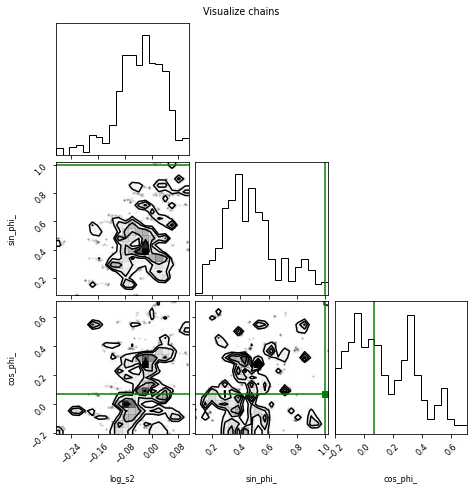

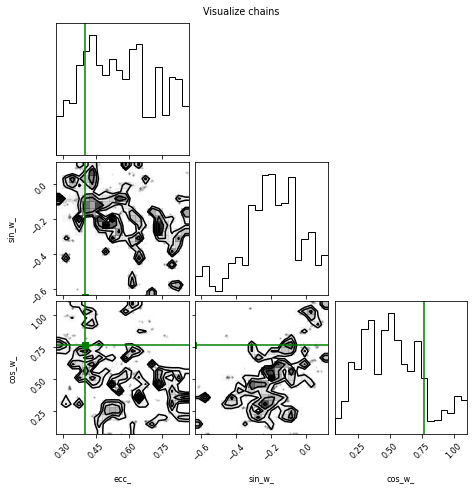

In [21]:
for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:
    n_dim = chains.shape[-1]
    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=0, n_last_spls=100)
    axes = np.array(fig_corner.axes).reshape((len(indices), len(indices)))
    for yy,yi in enumerate(indices):
        for xx,xi in enumerate(indices[:yy]):
            ax = axes[yy, xx]
            ax.plot(nf_samples[1][:, xi], nf_samples[1][:, yi], 'o', alpha=0.95)
    

Superpose chains + samples from the Flow

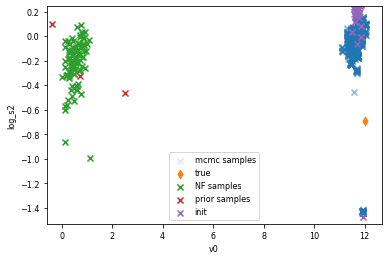

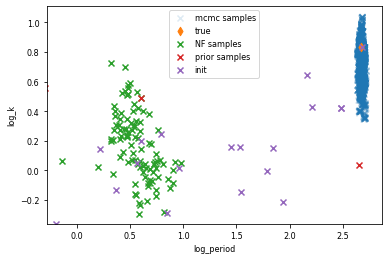

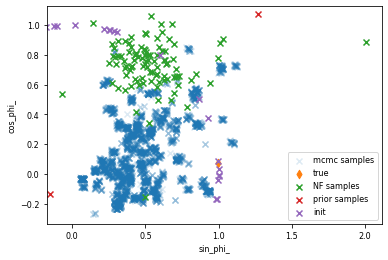

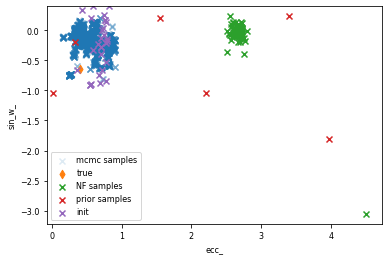

In [30]:
n_dim = chains.shape[-1]
indices = [0, 1]
for indices in [[0,1], [2,3], [4,5], [6,7]]:

    plt.figure()
    ax = plt.subplot(111)



    n_last_spls = 100
    samples = chains[:, -n_last_spls:, :].reshape(-1, n_dim)
    plt.scatter(samples[:, indices[0]], samples[:, indices[1]], alpha=0.15, label='mcmc samples', marker='x')
    plt.scatter(true_params[indices[0]], true_params[indices[1]], label='true', marker='d')
    plt.scatter(nf_samples[1][:, indices[0]], nf_samples[1][:, indices[1]], label='NF samples', marker='x')
    plt.scatter(prior_samples[:, indices[0]], prior_samples[:, indices[1]], alpha=1, label='prior samples', marker='x')
    ax.autoscale(False)
    plt.scatter(optimized_init[:, indices[0]], optimized_init[:, indices[1]], alpha=1, label='init', marker='x')
    
    plt.legend()
    plt.xlabel(labels[indices[0]])
    plt.ylabel(labels[indices[1]])



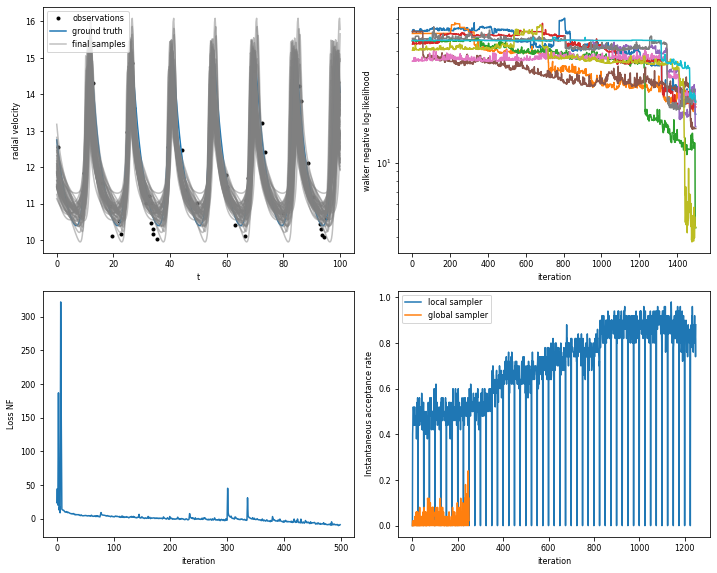

In [23]:

def log_posterior(x):
    return  log_likelihood(x.T, t, rv_err, rv_obs) + log_prior(x,**prior_kwargs)

fig_results = draw_kepler_results(chains, true_params, t, rv_obs, loss_vals,
                                  local_accs, global_accs, rv_model, log_posterior, get_kepler_params_and_log_jac)

Computing Rhat values

In [35]:
import arviz as az

dims = {ll : l for l,ll in enumerate(labels)}
n_last_spls = 1000
chains_data = az.convert_to_dataset(chains[:, -n_last_spls:, :], dims=dims)
chains_data
az.rhat(chains_data).values()

ValuesView(<xarray.Dataset>
Dimensions:  (x_dim_0: 9)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8
Data variables:
    x        (x_dim_0) float64 1.457 1.589 1.5 1.498 ... 1.472 1.383 1.597 1.424)

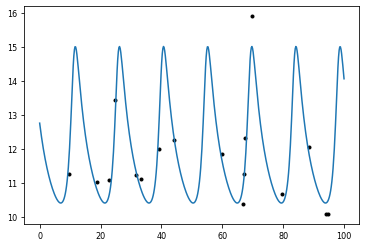

In [9]:
plt.plot(t, rv_obs, ".k", label='observations')
x = np.linspace(0, 100, 500)
plt.plot(x, rv_model(true_params, x), "C0", label='ground truth')